In [1]:
import sys
sys.path.append('/data_nfs/og86asub/netmap/netmap-evaluation/')

import scanpy as sc
import time 
import os.path as op
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import scipy.sparse as scs

import torch
import yaml


from netmap.src.utils.misc import write_config


from netmap.src.utils.data_utils import *
from netmap.src.utils.tf_utils import *
from netmap.src.utils.netmap_config import NetmapConfig

from netmap.src.model.train_model import create_model_zoo
from netmap.src.grn.inferrence import inferrence
from src.data_simulation.data_simulation_config import DataSimulationConfig
from netmap.src.masking.internal import *
from netmap.src.masking.external import *

import decoupler as dc
from netmap.src.masking.external import *
from netmap.src.downstream.edge_selection import *
from netmap.src.downstream.downstream import *


def read_config(file):
    with open(file, "r") as f:
        config = yaml.safe_load(f)
    return config





In [2]:
dataset_config = "/data_nfs/og86asub/netmap/netmap-evaluation/results/configurations/data_simulation/config_three_noise/net_60_10082_net_90_11013_net_75_10306_net_77_11506.config.yaml"
config = '/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_9/config_three/net_60_10082_net_90_11013_net_75_10306_net_77_11506/config.yaml'
dataset_config =DataSimulationConfig.read_yaml(dataset_config)

config = NetmapConfig.read_yaml(config)

{'input_data': '/data_nfs/og86asub/netmap/netmap-evaluation/data/simulated_data/config_three/net_60_10082_net_90_11013_net_75_10306_net_77_11506/data.h5ad', 'layer': 'X', 'output_directory': '/data_nfs/og86asub/netmap/netmap-evaluation/results/netmap/config_9/config_three/net_60_10082_net_90_11013_net_75_10306_net_77_11506', 'transcription_factors': '/data_nfs/datasets/SCENIC_DB/tf_lists/allTFs_hg38.txt', 'tf_only': False, 'penalize_error': True, 'adata_filename': 'grn_lrp.h5ad', 'grn': 'grn_lrp.tsv', 'masking_percentage': 0.1, 'print_every': 100, 'optimizer': 'Adam', 'learning_rate': 0.005, 'epochs': 10000, 'n_models': 10, 'validation_size': 0.2, 'model': 'ZINBAutoencoder', 'xai_method': 'GuidedBackprop', 'aggregation_strategy': 'mean'}


In [3]:

## load data
adata = sc.read_h5ad(config.input_data)

print(adata.shape)
## Get the data matrix from the CustumAnndata obeject

gene_names = np.array(adata.var.index)
model_start = time.monotonic()

if config.layer == 'counts':
    data_tensor = adata.layers['counts']
else:
    data_tensor = adata.X

if scs.issparse(data_tensor):
    data_tensor = torch.tensor(data_tensor.todense(), dtype=torch.float32)
else:
    data_tensor = torch.tensor(data_tensor, dtype=torch.float32)



##MAIN NETMAP PIPELINE:
# Create a bunch of models
model_zoo = create_model_zoo(data_tensor,  n_models=10, n_epochs=config.epochs, model_type='NegativeBinomialAutoencoder', dropout_rate=config.masking_percentage, hidden_dim = [64,64] )



(1500, 302)
Epoch 1/10000, Train Loss: 30.3668, Validation Loss: 25.8507
Epoch 1/10000, Train Loss: 30.3668
Epoch 2/10000, Train Loss: 20.9401
Epoch 3/10000, Train Loss: 12.7783
Epoch 4/10000, Train Loss: 9.1631
Epoch 5/10000, Train Loss: 7.7009
Epoch 6/10000, Train Loss: 6.9609
Epoch 7/10000, Train Loss: 6.4687
Epoch 8/10000, Train Loss: 6.1087
Epoch 9/10000, Train Loss: 5.7903
Epoch 10/10000, Train Loss: 5.5352
Epoch 11/10000, Train Loss: 5.3282, Validation Loss: 4.9152
Epoch 11/10000, Train Loss: 5.3282
Epoch 12/10000, Train Loss: 5.1387
Epoch 13/10000, Train Loss: 4.9975
Epoch 14/10000, Train Loss: 4.8830
Epoch 15/10000, Train Loss: 4.7937
Epoch 16/10000, Train Loss: 4.7229
Epoch 17/10000, Train Loss: 4.6805
Epoch 18/10000, Train Loss: 4.6337
Epoch 19/10000, Train Loss: 4.6122
Epoch 20/10000, Train Loss: 4.5859
Epoch 21/10000, Train Loss: 4.5556, Validation Loss: 4.4525
Epoch 21/10000, Train Loss: 4.5556
Epoch 22/10000, Train Loss: 4.5384
Epoch 23/10000, Train Loss: 4.5097
Epoch 24

In [4]:
from netmap.src.model.nbautoencoder import *

In [7]:
# Run gradient-shap on the models
grn_adata = inferrence(model_zoo, data_tensor.cuda(), gene_names,  config)

100%|██████████| 302/302 [03:44<00:00,  1.34it/s]


Creating anndata
Setting vars


# Downstream filtering and annotation pipeline

The GRN inference outputs a complete dataframe for all possible interactions. However, due to the nature of the model (=autoencoder) lowly expressed genes (and therefore edges) may be (over-imputed). Furthermore, we are not interested in all edges, we are primarily interested in the most explanatory edges. Therefore, we developed an extensive filtering and annotation pipeline to improve the interpretability of the output.

## Egde filtering
Edges are filtered on a per-cell basis. The function 'add_top_edge_annotation_global' performs a rough global filtering by selecting the %top_edges from each cell. Note, the top edges are not necessarily identical even between cells of the same cluster/group. Therefore, the filtered object contains more then %top_edges*grn_adata.shape[1] edges. In this initial step, it is also ok to set a lenient threshold as the goal is to just get rid of completely uniformative edges.

In the example below, the top 10% of edges are selected per cell. The method does not automatically remove edges, it rather annotated the number of cells a particular edge was among the %top_edges  edges in the object. You can set a vector to efficiently compute different thresholds. nan_fill=0 means the remaining edges will obtain an aritificial count of 0. It does not mean it has not been found at all, it just means that it was never among the %top edges in the data.


In [8]:
b = np.argsort(grn_adata.X, axis=1)
grn_adata.layers['sorted'] = b
grn_adata = add_top_edge_annotation_global(grn_adata, top_edges=[0.1], nan_fill=0)

grn_adata_filtered = grn_adata.copy()
grn_adata_filtered = process(grn_adata=grn_adata_filtered, n_clu=3, cluster_var = 'spectral')

82084
91204
clustering: 3 clusters


## Cluster based edge filtering
### Preprocess and cluster
After the initial filtering, you can subset the data to exlude the uninformative edges and cluster the data. Then you can proceed to clustering the GRN. The process function is a wrapper around common scanpy functions (PCA, neighbours, UMAP), and performs spectral clustering and stores the result of a spectral clustering run in the cluster_var variable. You can choose other clustering, e.g. leiden clustering here with standard scanpy functions. We add spectral clustering here, because it allows the user to set a number of clusters they think is likely present in the data.

In [9]:
grn_adata_filtered.X!=0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]],
      shape=(1500, 91204))

In [10]:
np.sum(grn_adata_filtered.var['global_cell_count_0.1']>500)

np.int64(7738)

In [11]:
sc.tl.umap(grn_adata_filtered)


In [12]:
grn_adata_filtered

AnnData object with n_obs × n_vars = 1500 × 91204
    obs: 'leiden', 'spectral'
    var: 'source', 'target', 'global_cell_count_0.1'
    uns: 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'sorted'
    obsp: 'distances', 'connectivities'

... storing 'source' as categorical
... storing 'target' as categorical


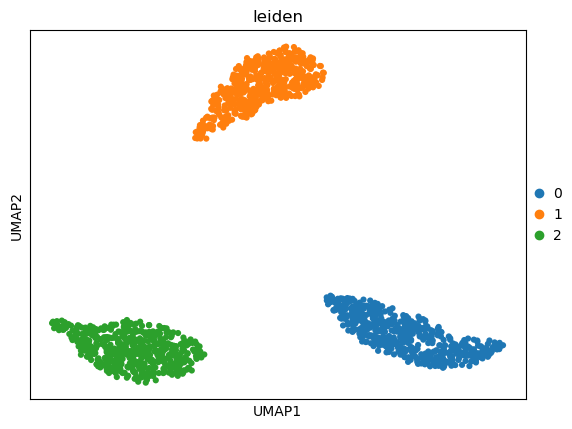

In [13]:
sc.pl.umap(grn_adata_filtered, color='leiden')

In [14]:
import numpy as np
import pandas as pd
import numpy as np
from collections import Counter


def _get_top_edges_global(grn_adata, top_edges: int, layer = 'X'):

    b = grn_adata.layers['sorted']
    # Calculate partition indices for all top_edges values
    top_edges_data_list = [int(np.round(grn_adata.shape[1] * t)) for t in top_edges]
    partition_indices = [grn_adata.shape[1]]+[grn_adata.shape[1] - n for n in top_edges_data_list]
    
    top = []
    edge_metadata_np = grn_adata.var.index.to_numpy()

    for i in range(len(partition_indices)-1):
        
        # part index is running backwards
        end_idx = partition_indices[i]
        start_index = partition_indices[i+1]
        top_idx = b[:, start_index:end_idx]
        print(start_index)
        print(end_idx)
        
        t_val = top_edges[i]

        top_edges_metadata = edge_metadata_np[top_idx.ravel()]
        edge_counts_map = Counter(top_edges_metadata.tolist())

        #top.append(get_top_edges_per_cell(grn_adata, top_idx, t_val))
        top.append(edge_counts_map)


    global_counter = top[0]
    final_df = [data_preprr(global_counter, edge_metadata_np, top_edges[0])]
    for i in range(1, len(top)):
        print('he')
        global_counter = global_counter + top[i]
        t_val = top_edges[i]
        final_df.append(data_preprr(global_counter, edge_metadata_np, t_val))
    
    final_df = np.concatenate(final_df)
    final_df = pd.DataFrame(final_df)
    return final_df

def data_preprr(global_counter, edge_metadata_np, top_edges_val):
    
    edge_keys_list = []
    cell_counts_list = []

    # Iterating over items() is generally faster than two separate list comprehensions
    for key, count in global_counter.items():
        edge_keys_list.append(key)
        cell_counts_list.append(count)

    # Convert to NumPy arrays
    edge_keys_np = np.array(edge_keys_list, dtype=edge_metadata_np.dtype)
    cell_counts_np = np.array(cell_counts_list, dtype=np.int32)

    # Get the size of the result
    N = len(edge_keys_np)

    # Define dtype_final using the *full* index data type
    dtype_final = np.dtype([
        # Use the dtype of the original index, which is now the complete index
        ('edge_key', edge_metadata_np.dtype),
        ('top_edges', np.float16),
        ('cell_count', np.int32)
    ])

    # Create the empty structured array
    final_summary_result = np.empty(N, dtype=dtype_final)

    # Populate the structured array fields
    # The index is now final_edge_keys
    final_summary_result['edge_key'] = edge_keys_np
    # The counts array is now cell_counts_reindexed
    final_summary_result['cell_count'] = cell_counts_np
    final_summary_result['top_edges'] = top_edges_val

    return final_summary_result

def add_top_edge_annotation_global(grn_adata, top_edges = [0.1], nan_fill = 0):

    var = grn_adata.var
    if var.index.name is None or var.index.name == 'index':
        var = var.reset_index()
        var = var.rename(columns = {'index':'edge_key'})
    else:
        var = var.reset_index()
        
    top_edges_per_cell = _get_top_edges_global(grn_adata,  top_edges, layer='X')
    print(top_edges_per_cell)

    for te in top_edges:
        if f'global_cell_count_{te}' in var.columns:
            var = var.drop(columns = [ f'global_cell_count_{te}'])
        print(top_edges_per_cell.loc[top_edges_per_cell.top_edges==te])
        var = var.merge(top_edges_per_cell.loc[top_edges_per_cell.top_edges==te, ['edge_key', 'cell_count']].rename(columns = {'cell_count': f'global_cell_count_{te}'}), left_on = 'edge_key', right_on='edge_key', how='outer')
        var[f'global_cell_count_{te}']= var[f'global_cell_count_{te}'].fillna(nan_fill)

    var = var.set_index('edge_key')
    grn_adata.var = var
    
    return grn_adata

def add_top_edge_annotation_cluster(local_grn_adata, top_edges = [0.1], nan_fill = 0, cluster_var = 'spectral'):
    var = local_grn_adata.var
    if var.index.name is None or var.index.name == 'index':
        var = var.reset_index()
        var = var.rename(columns = {'index':'edge_key'})
    else:
        var = var.reset_index()
        
    for clu in local_grn_adata.obs[cluster_var].unique():
        grn_adata_sub = local_grn_adata[local_grn_adata.obs[cluster_var] == clu]
        top_edges_per_cell = _get_top_edges_global(grn_adata_sub,  top_edges, layer='X')
        print(top_edges_per_cell)
        for te in top_edges:
            if f'cell_count_{te}_{clu}' in var.columns:
                var = var.drop(columns = [ f'cell_count_{te}_{clu}'])
            print(var)
            print(top_edges_per_cell.loc[top_edges_per_cell.top_edges==te])

            var = var.merge(top_edges_per_cell.loc[top_edges_per_cell.top_edges==te, ['edge_key', 'cell_count']].rename(columns = {'cell_count': f'cell_count_{te}_{clu}'}), left_on = 'edge_key', right_on='edge_key', how='outer')
            var[f'cell_count_{te}_{clu}']= var[f'cell_count_{te}_{clu}'].fillna(nan_fill)

    var = var.set_index('edge_key')
    local_grn_adata.var = var

    return local_grn_adata


In [15]:
grn_adata_filtered.obs

,leiden,spectral
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
1495,2,0
1496,2,0
1497,2,0
1498,2,0


### Edge selection
Like before, the data is not automatically subset, rather additional variables are added to the netmap object, for inspection. Again, the top %n percernt of edges per cell are selected, so more edges will be contained in the final data frame.

In [45]:


grn_adata_filtered = grn_adata.copy()
b = np.argsort(grn_adata_filtered.X, axis=1)
grn_adata_filtered.layers['sorted'] = b
grn_adata_filtered = process(grn_adata=grn_adata_filtered, n_clu=3, cluster_var = 'spectral')


clustering: 3 clusters


In [46]:

grn_adata_filtered = add_top_edge_annotation_cluster(grn_adata_filtered, top_edges=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], nan_fill=0, cluster_var='leiden')
grn_adata_filtered = add_top_edge_annotation_global(grn_adata_filtered, top_edges=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], nan_fill=0)


82084
91204
72963
82084
63843
72963
54722
63843
45602
54722
36482
45602
27361
36482
18241
27361
9120
18241
0
9120
he
he
he
he
he
he
he
he
he
             edge_key  top_edges  cell_count
0           SPG7_HAS2      0.100         361
1        CYSLTR2_MYL7      0.100         289
2        MRPS24_PTPRA      0.100         316
3           ATF1_IRF5      0.100          26
4       BMP10_RPS6KA3      0.100         124
...               ...        ...         ...
575490    LRRC10_IRF3      1.000         500
575491     COX5B_IL18      1.000         500
575492      IRX5_IL18      1.000         500
575493    NKX2-5_IL18      1.000         500
575494       KDR_IL18      1.000         500

[575495 rows x 3 columns]
                      edge_key       source       target  \
0                  AARS2_AARS2        AARS2        AARS2   
1                    AARS2_ACR        AARS2          ACR   
2                  AARS2_ACTA1        AARS2        ACTA1   
3                  AARS2_ACTA2        AARS2        A

In [47]:
import decoupler as dc
from netmap.src.masking.external import *
nets = [pd.read_csv(op.join( filename), sep=dataset_config.separator) for filename in dataset_config.edgelist]

n2 = nets[1]
n2['weight'] = 1
n1 = nets[0]
n1['weight'] = 1
n3 = nets[2]
n3['weight'] = 1
collectri = dc.op.collectri()
collectri = collectri.loc[:, ['source', 'target', 'weight']]
grn_adata_filtered = add_external_grn(grn_adata_filtered, collectri, 'collectri')
grn_adata_filtered = add_external_grn(grn_adata_filtered, n1, 'net0')
grn_adata_filtered = add_external_grn(grn_adata_filtered, n2, 'net1')
grn_adata_filtered = add_external_grn(grn_adata_filtered, n3, 'net2')

In [49]:
df = grn_adata_filtered.var

df= df.reset_index()

cell_count_cols_full = [
    col for col in df.columns
    if col.startswith('cell_count_') and len(col.split('_')) == 4
]

df_melted = df.melt(
    id_vars=['source', 'target', 'edge_key'],
    value_vars=cell_count_cols_full,
    var_name='metric_cluster',
    value_name='cell_count'
)

In [51]:
 grn_adata_filtered.var[ grn_adata_filtered.var.edge_in_net1==1].index

Index(['ANKRD1_NPPA', 'FOXC1_DLL4', 'GATA4_ACTA2', 'GATA4_ANKRD1',
       'GATA4_ATP2A2', 'GATA4_BMP2', 'GATA4_CORIN', 'GATA4_CTNNA3',
       'GATA4_GJA5', 'GATA4_HEY1',
       ...
       'TBX6_HES7', 'TBX6_MSGN1', 'TBX6_WNT3A', 'ZFPM2_ATP2A2', 'ZFPM2_KCND2',
       'ZFPM2_LHX9', 'ZFPM2_NPPA', 'ZNF260_NPPA', 'ZNF384_EFNB2',
       'ZNF384_KDR'],
      dtype='object', name='edge_key', length=216)

In [52]:
df_melted['threshold'] = df_melted['metric_cluster'].str.split('_').str[2]
df_melted['cluster_id'] = df_melted['metric_cluster'].str.split('_').str[3]

# Convert columns to correct types for plotting
df_melted['threshold'] = pd.to_numeric(df_melted['threshold'])
df_melted['cluster_id'] = df_melted['cluster_id'].astype(str)

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

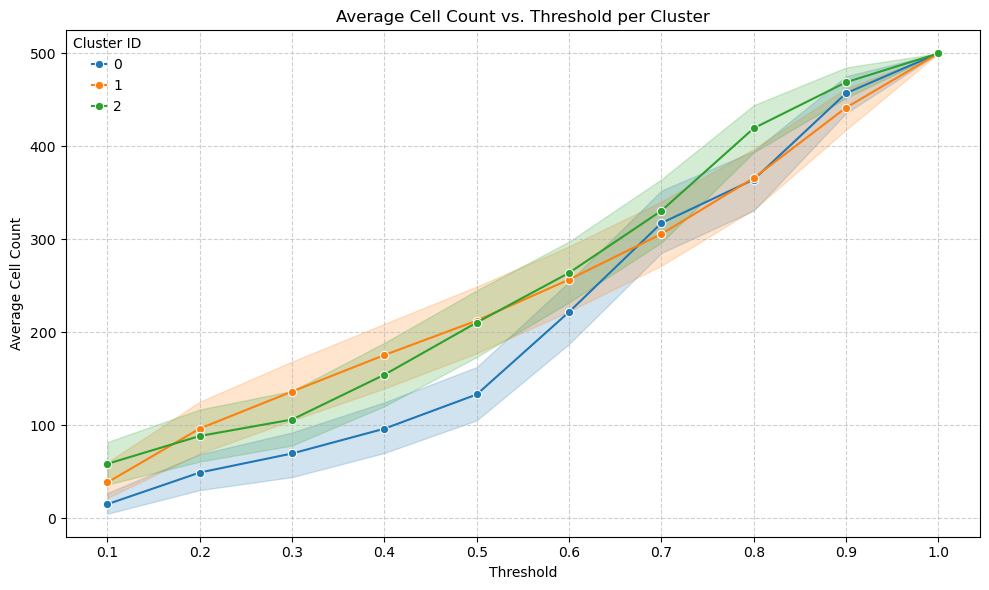

In [59]:
plt.figure(figsize=(10, 6))
df_plot = df_melted.sort_values(by='threshold')

g = sns.lineplot(
    data=df_melted[(df_melted.edge_key.isin( grn_adata_filtered.var[ grn_adata_filtered.var.edge_in_net2==1].index))],
    x='threshold',
    y='cell_count',
    hue='cluster_id',
    marker='o',
    dashes=False
)


# Customize the plot
plt.title('Average Cell Count vs. Threshold per Cluster')
plt.xlabel('Threshold')
plt.ylabel('Average Cell Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster ID')
plt.xticks(df_plot['threshold'].unique())
plt.tight_layout()

In [70]:
df_melted[(df_melted.edge_key.isin( grn_adata_filtered.var[ grn_adata_filtered.var.edge_in_net2==1].index))].groupby(['threshold', 'cluster_id']).sum()['cell_count']

threshold  cluster_id
0.100      0             2676.000
           1             6774.000
           2            10267.000
0.200      0             8625.000
           1            16899.000
           2            15505.000
0.300      0            12210.000
           1            23867.000
           2            18598.000
0.400      0            16879.000
           1            30736.000
           2            27037.000
0.500      0            23319.000
           1            37205.000
           2            36849.000
0.600      0            38849.000
           1            44944.000
           2            46204.000
0.700      0            55569.000
           1            53515.000
           2            57891.000
0.800      0            63762.000
           1            64052.000
           2            73415.000
0.900      0            80002.000
           1            77296.000
           2            82070.000
1.000      0            87500.000
           1            87

## Add external data base information to your object
External Transcription factor -target databases can be mapped to your GRN-adata object easily by the following method. In the example here, we use collectri via the decoupler API.
After executing the add_external_grn function, you have extra annotations in the var columns: The edge weight of the edge in the external GRN, and additionally whether which genes were found as TFs and which as Target. Duplicate entries will be collapsed!

## Add gene clustering information to your data frame
Highly correlated genes may be regulated by the same transcription factor. Therefore it can be useful to cluster these genes and analye them as a group. To do this, you can employ hierarchicahl clustering on the original gene expression data. Here, this analysis can be done in four steps using hierarchical clustering
1. Compute the linkage and the tree distance 
2. Plot the a scatter plot between the tree distance and the correlation to identify a rough tree distance cutoff where the distance between genes becomes very large and uninformative. 
3. Compute a linear regression (quantile regression (fit it such that the data is bounded from below)) on the thresholded data. Based on the intersect of your regression line with a correlation threshold (average required correlation between the clusters in your data) of your choice you can then select the final three threshold at which the tree will be cut to form the clusters.
4. Finally, add the clustering information to your GEX adata object and merge with your GRN adata object to obtain an annotated object.

### Linkage 

In [ ]:
from netmap.src.downstream.gene_clustering import *

df, dist_linkage = get_hierarchical_clustering(adata, genes=None)

### Compute a scatter plot between the tree-distance (cophenetic distance) and the correlation between the genes.
Pick a threshold (vizually) where you can approximatelty fit a linear model. 

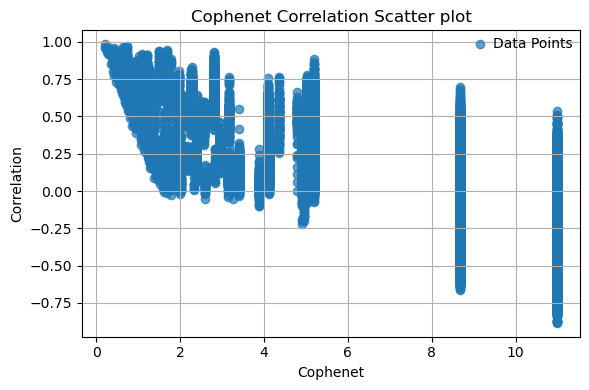

In [ ]:
plot_scatter_plot(df)

### Choose a linkage cutoff
Choose a cophenetic threshold (here: 1.8) and a corrleation threshold. The correlation threhold is the minimal average correlation of the genes in the cluster.

Automatically determined cluster cutoff distance: 0.7793


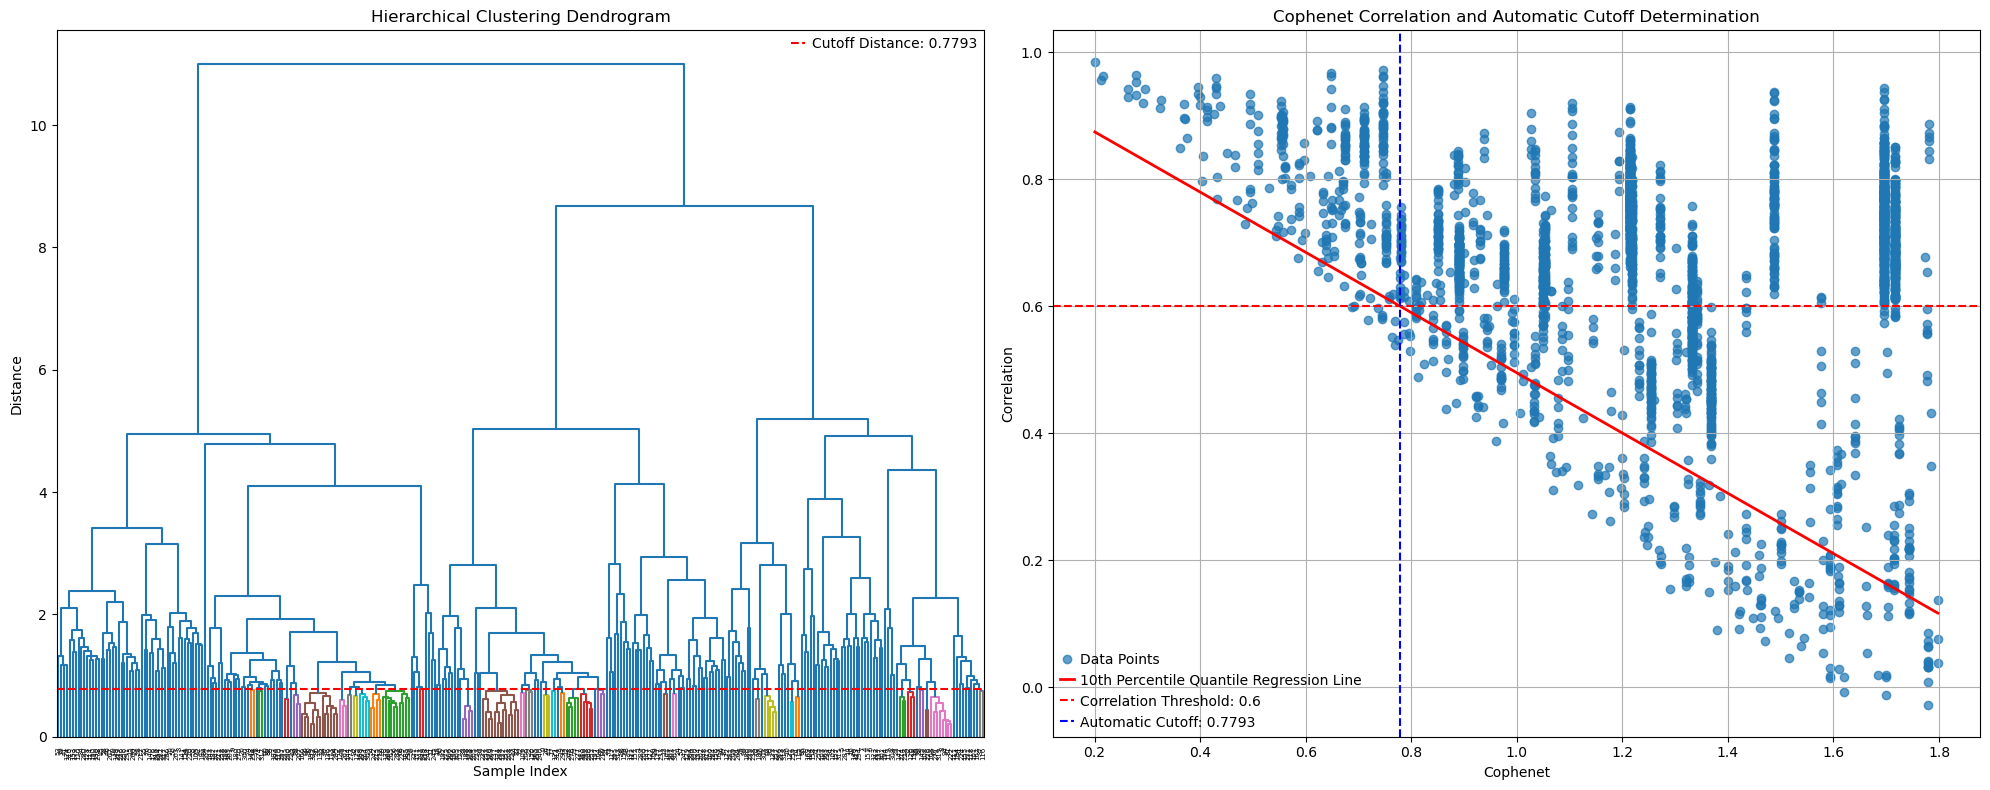

In [ ]:
cutoff = compute_regression(df, cophenet_threshold=1.8, dist_linkage = dist_linkage, correlation_threshold=0.6)

In [ ]:
adata = add_clusters_to_adata(adata, cutoff_distance=cutoff, dist_linkage=dist_linkage, cluster_var='target_cluster')

In [ ]:
grn_adata_filtered.var = grn_adata_filtered.var.reset_index().merge(adata.var, left_on='target', right_on= 'genes')
grn_adata_filtered.var = grn_adata_filtered.var.set_index('edge_key')

### Reinsert missingness
Since expression data is often noisy and prone to dropout you can reinsert the missingness which has been imputed due to the autoencoder.
There are two modes:
1. stict mode: If for an egde (e1,e2) either e1, e2 or both are not expressed, then the 'expression' of that edge will be set to 0 in the GRN data frame.
2. knn mode: If for an edge (e1,e2) e1, or e2 are not expressed in the cell and also not in the direct knn-neighborhood (set desirable thresholds) then the edge expression will be set to 0.


In [ ]:
grn_adata_filtered = add_neighbourhood_expression_mask(adata, grn_adata_filtered)

In [ ]:
# import numpy as np
# import pandas as pd

# # Define manageable dimensions for demonstration
# NUM_CELLS = 1500
# NUM_EDGES = 4000000

# # 1. Create a small example data matrix (equivalent to grn_adata.X)
# # The values represent the edge weights for each cell.
# np.random.seed(42) # for reproducible results
# data_example = np.random.rand(NUM_CELLS, NUM_EDGES)
# print("--- Example Data Matrix (4 cells x 10 edges) ---")
# print(data_example.round(2))

# # 2. Perform argsort row-wise (axis=1)
# # 'b' will contain the indices that would sort each row.
# # We are interested in the indices of the largest elements (highest edge weights).
# b = np.argsort(data_example, axis=1)